<a href="https://colab.research.google.com/github/m-shilpa/Airfoil-Self-Noise-Capstone1-ML/blob/master/S2-MobileNets_and_ShuffleNets/Extras/Shilpa/MobilenetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Unzip the dataset

In [2]:
def unzip_files(filename = '/content/gdrive/My Drive/e4p2/dataset.zip'):
  
  from zipfile import ZipFile 
  import os

  # for i in os.listdir(File):
  #   filename = f'{File}/{i}'
  #   print(filename)
  # opening the zip file in READ mode 
  with ZipFile(filename, 'r') as zip_file: 
    
      # extracting all the files 
      print('Extracting all the files now...') 
      zip_file.extractall() 
      print('Done!')

In [3]:
# unzip_files(filename='/content/gdrive/My Drive/e4p2/dataset_padded.zip')

In [4]:
!pip install torchsummary
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-k6g53t1h
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-k6g53t1h
  Created wheel for albumentations: filename=albumentations-0.4.6-cp36-none-any.whl size=65436 sha256=cd3573d8f0c36c8cfab3ab21bf53e7bbaa5f98c24b5c455a93f8237a7f7cf982
  Stored in directory: /tmp/pip-ephem-wheel-cache-_84c3vdi/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.6
    Uninstalling albumentations-0.4.6:
      Successfully uninstalled albumentations-0.4.6


In [5]:
import os

# Loading the dataset

In [6]:
# data loader
from torch.utils.data import Dataset
import random
import numpy as np
import torch
from PIL import Image

def get_data(label_file='/content/gdrive/My Drive/e4p2/labels_num.txt',length=None):
    images = []
    target = []
    
    if length == None:
      labels = (open(label_file,'r')).readlines()
    else:
      labels = (open(label_file,'r')).readlines()[:length]
    for label in labels:
      a  = label.split(' ')
      images.append(f'/content/Dataset/{a[0]}')
      l = a[1].split('\n')
      target.append(l[0])         
    dataset =  list(zip(images,target))
    random.shuffle(dataset)
    train_split = 70
    train_len = len(dataset)*train_split//100
    train = dataset[:train_len]
    test = dataset[train_len:]
    return train,test

class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        
        self.input_images,target = zip(*data) 
        self.target = np.asarray(target)
        self.target = torch.from_numpy(self.target.astype('long'))

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
  
        # print(self.target[idx],'---',idx,'----')
        input_image = np.asarray(Image.open(self.input_images[idx]))
        target = self.target[idx]
        
        if self.transform:
            input_image = self.transform(image=input_image)['image']
                    
        return input_image,target

def form_data(unzip=False,length =None, train_transform =None,test_transform =None):

  if unzip == True:
    unzip_files(filename='/content/gdrive/My Drive/e4p2/dataset_padded.zip')
  else:
    print('Files already downloaded')
  print('Forming the dataset')
  train, test = get_data(length=length)

  train_set = CustomDataset(train,transform=train_transform )
  test_set = CustomDataset(test,transform=test_transform )
  print('Done!')
  return train_set, test_set

In [7]:
# augmentations
import albumentations as A
import albumentations.pytorch as AP

mean = (0.53105756 , 0.58601165 , 0.61593276)

std = (0.28278487,  0.25762487 , 0.29407342)
	
train_transform = A.Compose(
    [ 
     
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1),
     A.Flip(always_apply=False, p=0.5), 
     A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.1, rotate_limit=45, 
                        interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
     A.RandomContrast(limit=0.2, always_apply=False, p=0.5),
    #  A.ChannelShuffle(always_apply=False, p=0.5),
    #  A.GridDistortion(num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4,
    #                   value=None, mask_value=None, always_apply=False, p=0.5),
     A.Cutout(num_holes=4, max_h_size=32,max_w_size = 32,p=1,fill_value=0.5*255), 
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])
            
test_transform = A.Compose(
    [ 
     A.Resize(224, 224, interpolation=1, always_apply=True, p=1),
     A.Normalize(mean=mean, std=std),
     AP.ToTensor()        
             ])



In [8]:
train_set,test_set = form_data(unzip=False, train_transform=train_transform, test_transform=test_transform )                                        

Files already downloaded
Forming the dataset
Done!


In [9]:
# %%file data_load.py

import torch
import torchvision



def load(train_set,test_set,seed=1,batch_size=128,num_workers=4,pin_memory=True):
	
	SEED = 1

	# CUDA?
	cuda = torch.cuda.is_available()


	# For reproducibility
	torch.manual_seed(SEED)

	if cuda:
			torch.cuda.manual_seed(SEED)

	# dataloader arguments - something you'll fetch these from cmdprmt
	dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory) if cuda else dict(shuffle=True, batch_size=64)

	trainloader = torch.utils.data.DataLoader(train_set, **dataloader_args)
	testloader = torch.utils.data.DataLoader(test_set, **dataloader_args)


	return  trainloader, testloader

In [10]:
trainloader,testloader = load(train_set,test_set,batch_size=128)

# Display the images

shape: torch.Size([128, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Large_QuadCopters Flying_Birds Winged_Drones Large_QuadCopters Flying_Birds


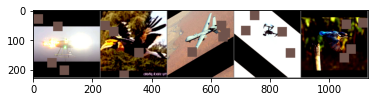

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def show_random_images(dataset, classes):

	# get some random training images
	dataiter = iter(dataset)
	images, labels = dataiter.next()

	img_list = range(5, 10)

	# show images
	print('shape:', images.shape)
	imshow(torchvision.utils.make_grid(images[img_list]))
	# print labels
  
	print(' '.join('%5s' % classes[int(labels[j])] for j in img_list))
 
show_random_images(trainloader, classes)

# Loading the model

In [12]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


cuda


In [13]:
from torchsummary import summary

In [14]:
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True).to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_master


In [15]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvBNReLU(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNReLU(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=Tr

In [16]:
# # Freeze model weights
# for param in model.parameters():
#     param.requires_grad = False

In [17]:
import torch.nn as nn
# model.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True).cuda()
model.classifier[1] = nn.Sequential(
                      nn.Linear(1280, 256), 
                      nn.ReLU(), 
                      # nn.Dropout(0.4),
                      nn.Linear(256, 4),                   
                      ).cuda()

In [18]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [19]:
# %load_ext tensorboard

In [20]:
# from torch.utils.tensorboard import SummaryWriter
# tb = SummaryWriter(flush_secs=5)
# data,target = next(iter(trainloader))
# data,target = data.to(device), target.to(device)
# tb.add_graph(model,data)
# tb.close()

In [21]:
# %tensorboard --logdir=runs

# Training and testing

In [22]:

class Train_test:
  
  def __init__(self):
    self.train_losses = []
    self.test_losses = []
    self.train_acc = []
    self.test_acc = []
    self.train_acc_epoch_end = []
    self.train_loss_epoch_end = []

  def train_and_test(self,model, device, train_loader,test_loader, optimizer, criterion, epoch):
      
    
    self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end = self.train(model, device, train_loader, optimizer, criterion)
    self.test_losses,self.test_acc = self.test(model, device, criterion, test_loader)
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end,self.test_losses,self.test_acc


  def train(self,model, device, train_loader, optimizer, criterion):

    import torch
    #Training & Testing Loops
    from tqdm import tqdm

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      # target = np.asarray(target)
      # target = torch.from_numpy(target.astype('long'))
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      # loss = F.nll_loss(y_pred, target)
      loss = criterion(y_pred, target)
      self.train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      self.train_acc.append(100*correct/processed)
    self.train_acc_epoch_end.append(self.train_acc[-1])
    self.train_loss_epoch_end.append(self.train_losses[-1])
    return self.train_acc,self.train_acc_epoch_end,self.train_losses,self.train_loss_epoch_end


  def test(self,model, device, criterion, test_loader):

      import torch
    #Training & Testing Loops
      from tqdm import tqdm

      model.eval()
      test_loss = 0
      correct = 0
      with torch.no_grad():
          for data, target in test_loader:
              # target = np.asarray(target)
              # target = torch.from_numpy(target.astype('long'))
              data, target = data.to(device), target.to(device)
              output = model(data)
              test_loss += criterion(output, target).item()  # sum up batch loss
              pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
              correct += pred.eq(target.view_as(pred)).sum().item()
              

      test_loss /= len(test_loader.dataset)
      self.test_losses.append(test_loss)

      print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
          test_loss, correct, len(test_loader.dataset),
          100. * correct / len(test_loader.dataset)))
      
      self.test_acc.append(100. * correct / len(test_loader.dataset))
      return self.test_losses,self.test_acc


In [23]:
# import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler

In [24]:
# model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True).to(device)
# model.classifier[1] = nn.Linear(in_features=1280, out_features=4, bias=True).cuda()

In [25]:
# use_cuda = torch.cuda.is_available()
# device = torch.device("cuda" if use_cuda else "cpu")


EPOCHS = 10
l_rate = []
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.9) 
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5, last_epoch=-1)
train_test = Train_test()
# i=0
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1, 'LR:',optimizer.param_groups[0]['lr'])
    l_rate.append(optimizer.param_groups[0]['lr'] )
    train_acc,train_acc_epoch_end,train_losses,train_loss_epoch_end,test_losses,test_acc = train_test.train_and_test(model, device, trainloader,testloader, optimizer, criterion, epoch)
    scheduler.step()

  0%|          | 0/117 [00:00<?, ?it/s]

EPOCH: 1 LR: 0.001


Loss=0.7437579035758972 Batch_id=116 Accuracy=55.75: 100%|██████████| 117/117 [05:15<00:00,  2.70s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0051, Accuracy: 4774/6401 (74.58%)

EPOCH: 2 LR: 0.001


Loss=0.6595360040664673 Batch_id=116 Accuracy=77.79: 100%|██████████| 117/117 [05:15<00:00,  2.69s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 5235/6401 (81.78%)

EPOCH: 3 LR: 0.001


Loss=0.4757564961910248 Batch_id=116 Accuracy=80.75: 100%|██████████| 117/117 [05:15<00:00,  2.70s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 5299/6401 (82.78%)

EPOCH: 4 LR: 0.001


Loss=0.39191511273384094 Batch_id=116 Accuracy=82.16: 100%|██████████| 117/117 [05:21<00:00,  2.74s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 5393/6401 (84.25%)

EPOCH: 5 LR: 0.001


Loss=0.48693394660949707 Batch_id=116 Accuracy=82.85: 100%|██████████| 117/117 [05:22<00:00,  2.75s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 5436/6401 (84.92%)

EPOCH: 6 LR: 0.001


Loss=0.4980103075504303 Batch_id=116 Accuracy=83.72: 100%|██████████| 117/117 [05:14<00:00,  2.69s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 5452/6401 (85.17%)

EPOCH: 7 LR: 0.001


Loss=0.26254135370254517 Batch_id=116 Accuracy=84.06: 100%|██████████| 117/117 [05:14<00:00,  2.69s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5497/6401 (85.88%)

EPOCH: 8 LR: 0.001


Loss=0.3182004392147064 Batch_id=116 Accuracy=84.90: 100%|██████████| 117/117 [05:25<00:00,  2.78s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0028, Accuracy: 5496/6401 (85.86%)

EPOCH: 9 LR: 0.001


Loss=0.3661048710346222 Batch_id=116 Accuracy=85.47: 100%|██████████| 117/117 [05:25<00:00,  2.79s/it]
  0%|          | 0/117 [00:00<?, ?it/s]


Test set: Average loss: 0.0027, Accuracy: 5500/6401 (85.92%)

EPOCH: 10 LR: 0.001


Loss=0.3155847191810608 Batch_id=116 Accuracy=85.66: 100%|██████████| 117/117 [05:22<00:00,  2.76s/it]



Test set: Average loss: 0.0028, Accuracy: 5551/6401 (86.72%)



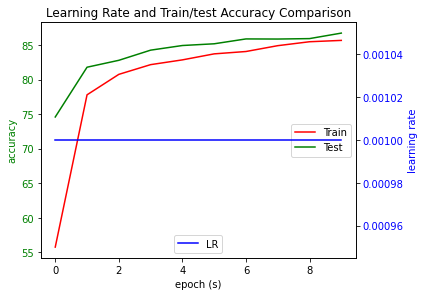

In [31]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()

ax1.set_xlabel('epoch (s)')
ax1.set_ylabel('accuracy', color='g')
testline, = ax1.plot( test_acc, color='g')
ax1.tick_params(axis='y', labelcolor='g')

trainline, = ax1.plot( train_acc_epoch_end, color='r')
ax1.legend((trainline, testline), ('Train', 'Test'), loc=7)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis


ax2.set_ylabel('learning rate', color='b')  # we already handled the x-label with ax1
lrline, = ax2.plot( l_rate, color='b')
ax2.legend((lrline, ), ('LR',), loc=8)
ax2.tick_params(axis='y', labelcolor='b')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Learning Rate and Train/test Accuracy Comparison")
plt.show()

In [28]:
# classwise accuracy
classes = ['Winged_Drones', 'Small_QuadCopters', 'Large_QuadCopters', 'Flying_Birds' ]

def evaluate_classwise_accuracy(model, device, classes, test_loader):
    class_correct = list(0. for i in range(4))
    class_total = list(0. for i in range(4))
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            
            for i in range(4):
            	label = labels[i]
            	class_correct[label] += c[i]
            	class_total[label] += 1

    for i in range(4):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

# evaluate_classwise_accuracy(model, device, classes, testloader)

In [29]:
# misclassified images of each class 
def show_misclassified_images(model, device, test_loader,classes,num=25):
  correct = 0
  misclassify = []
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
          correct += pred.eq(target.view_as(pred)).sum().item()
          
          for i in range(len(pred)):
            if pred[i] != target[i]:              
              if len(misclassify)==0:
                misclassify.append([data[i]])
                misclassify.append([classes[pred[i]]])
                misclassify.append([classes[target[i]]])
              else:
                misclassify[0].append(data[i])
                misclassify[1].append(classes[pred[i]])
                misclassify[2].append(classes[target[i]])

  j=0
  fig = plt.figure(figsize=(15,15)) 
  for i in range(num): 
      ax = fig.add_subplot(5,5 , 1 + j) # 4 rows, 3 columns, 1+j is the index which gives position of each image in the plot
      imshow(misclassify[0][i].cpu()) # display the image
      title = "Predicted: "+ str(misclassify[1][i])+"\nTarget: "+ str(misclassify[2][i])
      ax.set_title(title) # give the class of the image as its title
      j+=1
  plt.subplots_adjust( hspace=0.5, wspace=0.35)      
  plt.show()
  return misclassify # in the format[[image],[predict],[target]]

In [30]:
# misclassify = show_misclassified_images(model, device, testloader,classes,num=25)